# Reddit Classifier

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement:" data-toc-modified-id="Problem-Statement:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement:</a></span></li><li><span><a href="#Executive-summary" data-toc-modified-id="Executive-summary-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Executive summary</a></span></li><li><span><a href="#Scraping-for-data" data-toc-modified-id="Scraping-for-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scraping for data</a></span></li><li><span><a href="#Read-the-csv-file" data-toc-modified-id="Read-the-csv-file-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Read the csv file</a></span></li><li><span><a href="#EDA:-Exploring-the-dataset" data-toc-modified-id="EDA:-Exploring-the-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA: Exploring the dataset</a></span><ul class="toc-item"><li><span><a href="#Word-Cloud-visualization-for-dataset" data-toc-modified-id="Word-Cloud-visualization-for-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Word Cloud visualization for dataset</a></span></li></ul></li><li><span><a href="#Feature-Engineering-:-Train-test-split" data-toc-modified-id="Feature-Engineering-:-Train-test-split-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Engineering : Train test split</a></span><ul class="toc-item"><li><span><a href="#Creating-X-and-y" data-toc-modified-id="Creating-X-and-y-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Creating X and y</a></span></li><li><span><a href="#Baseline-accuracy" data-toc-modified-id="Baseline-accuracy-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Baseline accuracy</a></span></li></ul></li><li><span><a href="#NLP-Pipeline" data-toc-modified-id="NLP-Pipeline-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>NLP Pipeline</a></span><ul class="toc-item"><li><span><a href="#Tokenizing,-Stemming/Lemming-and-Vectorization" data-toc-modified-id="Tokenizing,-Stemming/Lemming-and-Vectorization-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Tokenizing, Stemming/Lemming and Vectorization</a></span></li><li><span><a href="#Model-1-:-Count-Vectorizer---Logistic-Regression" data-toc-modified-id="Model-1-:-Count-Vectorizer---Logistic-Regression-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Model 1 : Count Vectorizer - Logistic Regression</a></span></li><li><span><a href="#Model-2-:-Count-Vectorizer---Lemmatizer---Logistic-Regression" data-toc-modified-id="Model-2-:-Count-Vectorizer---Lemmatizer---Logistic-Regression-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Model 2 : Count Vectorizer - Lemmatizer - Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Scores-and-best-parameters-obtained-from-Grid-Search-based-on-this-dataset-is:" data-toc-modified-id="Scores-and-best-parameters-obtained-from-Grid-Search-based-on-this-dataset-is:-7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span>Scores and best parameters obtained from Grid Search based on this dataset is:</a></span></li></ul></li><li><span><a href="#Model-3-:-Count-Vectorizer---Porter-Stemmer---Logistic-Regression" data-toc-modified-id="Model-3-:-Count-Vectorizer---Porter-Stemmer---Logistic-Regression-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Model 3 : Count Vectorizer - Porter Stemmer - Logistic Regression</a></span></li><li><span><a href="#Model-4-:-Count-Vectorizer---Lemmatizer---Multinomial-Naive-Bayes" data-toc-modified-id="Model-4-:-Count-Vectorizer---Lemmatizer---Multinomial-Naive-Bayes-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Model 4 : Count Vectorizer - Lemmatizer - Multinomial Naive Bayes</a></span></li><li><span><a href="#Model-5-:-TF-IDF---Lemmatizer---Multinomial-Naive-Bayes" data-toc-modified-id="Model-5-:-TF-IDF---Lemmatizer---Multinomial-Naive-Bayes-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Model 5 : TF-IDF - Lemmatizer - Multinomial Naive Bayes</a></span></li><li><span><a href="#Model-6-:-TF-IDF---Lemmatizer---Multinomial-Naive-Bayes-Model-2" data-toc-modified-id="Model-6-:-TF-IDF---Lemmatizer---Multinomial-Naive-Bayes-Model-2-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>Model 6 : TF-IDF - Lemmatizer - Multinomial Naive Bayes Model 2</a></span><ul class="toc-item"><li><span><a href="#Intepreting-Model-4" data-toc-modified-id="Intepreting-Model-4-7.7.1"><span class="toc-item-num">7.7.1&nbsp;&nbsp;</span>Intepreting Model 4</a></span></li></ul></li><li><span><a href="#Model-5-:-Gradient-Boosting-Classifier" data-toc-modified-id="Model-5-:-Gradient-Boosting-Classifier-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span>Model 5 : Gradient Boosting Classifier</a></span></li></ul></li><li><span><a href="#Model-Benchmarks" data-toc-modified-id="Model-Benchmarks-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Optimizing-for-Recall" data-toc-modified-id="Optimizing-for-Recall-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Optimizing for Recall</a></span></li><li><span><a href="#Plotting-the-AUC-ROC-Curve-of-the-best-model" data-toc-modified-id="Plotting-the-AUC-ROC-Curve-of-the-best-model-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Plotting the AUC ROC Curve of the best model</a></span></li><li><span><a href="#Plotting-the-distribution-of-probabilities" data-toc-modified-id="Plotting-the-distribution-of-probabilities-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Plotting the distribution of probabilities</a></span></li></ul></li><li><span><a href="#Visualizing-the-most-frequent-words-in-each-subreddit" data-toc-modified-id="Visualizing-the-most-frequent-words-in-each-subreddit-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualizing the most frequent words in each subreddit</a></span></li><li><span><a href="#Export-the-best-Model" data-toc-modified-id="Export-the-best-Model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Export the best Model</a></span></li><li><span><a href="#Running-the-final-model-on-Test-set" data-toc-modified-id="Running-the-final-model-on-Test-set-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Running the final model on Test set</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Problem Statement:

The participation rate at a local church have been declining over the years. The church committee would like to reconnect with the Christian community by emailing event updates to existing and occasional churchgoers. The committee have approached us to build a system that is able to identify Christians from their online posts as they do not want to hard sell on atheists.


## Executive summary
This is a classification problem where we will build a model that is able to identify Christians from atheists based on their online posts. 
As reddit has a big community for both Christians and atheists, we will scape reddit for the two topics and train a binary classifier that will classify which group a poster is from based on their text input


## Scraping for data

In [1]:
# !!!! Set the topic and filename here!

#AskDocs and LegalAdvice
# reddit_topics= ['AskDocs','legaladvice']
# filename = 'reddit_legal_doc.csv'

reddit_topics= ['Christianity','atheism']
filename='reddit_atheism_christianity.csv'

In [2]:
import requests
import pandas as pd
import numpy as np

In [3]:
from collections import defaultdict

def extract_content(response, topic):
    # 0th index refers to title appended with selftext
    rslt = defaultdict(list)
    for post in response.json()['data']['children']:
        rslt['content'].append(post['data']['title'] + ' ' + post['data']['selftext'])
        rslt['topic'].append(topic)
        rslt['id'].append(post['data']['name'])
        
    return rslt

def scrape_topic(topic,depth=12):
    '''
    Scrape the reddit topic for all the posts
    
    '''
    base_url = 'https://www.reddit.com/r/'
    url = base_url + topic + '.json?limit=100'
    last_entry_name = ''
    payload = None
    
    
    for i in range(depth):
        if last_entry_name == None:
            break
        if last_entry_name != '':
            url = base_url + topic + '.json?limit=100&after=' + last_entry_name
    
        res = requests.get(url, headers={'User-agent': 'Pony Inc 1.0'})
        print(f"request url: {url} for {topic} at depth:{i}")
        
        last_entry_name = res.json()['data']['after']
        print(f"Last entry name : {last_entry_name} ")
        content = extract_content(res,topic)
        if not payload:
            payload = content
        else:
            for k,v in payload.items():
                payload[k] += content[k]
        if i < depth-1:
            sleep_duration = random.randint(2,15)
            time.sleep(sleep_duration)
        print(f'Scraping {topic}, {i} pages in..')
    return {'topic': topic, 'data': payload }
    

In [4]:
import concurrent.futures as cf
import random, time


def get_reddit_data(topics):
    '''
    Main function to scrape reddit data into a pandas dataframe.
    Args: topics
     - An array object of topics in reddit to scrape from
    '''
    rdf = pd.DataFrame()
    with cf.ThreadPoolExecutor(max_workers=5) as executor:
        for future in executor.map(scrape_topic, topics):
            if rdf.empty:
                rdf = pd.DataFrame(future['data'])
            else:
                new = pd.DataFrame(future['data'])
                rdf = pd.concat([rdf,new],ignore_index=True)
            
    return rdf
        
      

In [5]:
import os.path

rdf = get_reddit_data(reddit_topics)
print(rdf.groupby(by='topic').count())

# filename = 'reddit_scrape_bio_chem.csv'
# filename = 'reddit_scrape_docs_legal.csv'


use_header=True

if os.path.exists(filename):
    use_header = False

# Append the data into a csv file
rdf.to_csv(filename,mode='a',header=use_header, index=False)

request url: https://www.reddit.com/r/Christianity.json?limit=100 for Christianity at depth:0
Last entry name : t3_dmbta1 
request url: https://www.reddit.com/r/atheism.json?limit=100 for atheism at depth:0
Last entry name : t3_dmbc5g 
Scraping Christianity, 0 pages in..
Scraping atheism, 0 pages in..
request url: https://www.reddit.com/r/Christianity.json?limit=100&after=t3_dmbta1 for Christianity at depth:1
Last entry name : t3_dm7yq8 
request url: https://www.reddit.com/r/atheism.json?limit=100&after=t3_dmbc5g for atheism at depth:1
Last entry name : t3_dlkdnk 
Scraping Christianity, 1 pages in..
request url: https://www.reddit.com/r/Christianity.json?limit=100&after=t3_dm7yq8 for Christianity at depth:2
Last entry name : t3_dlotnu 
Scraping Christianity, 2 pages in..
Scraping atheism, 1 pages in..
request url: https://www.reddit.com/r/Christianity.json?limit=100&after=t3_dlotnu for Christianity at depth:3
Last entry name : t3_dlaqg3 
request url: https://www.reddit.com/r/atheism.js

## Read the csv file

In [6]:
reddit_df = pd.read_csv(filename)

In [7]:
reddit_df

,content,topic,id
0,Mere Disagreement is Not a Personal Attack Thi...,Christianity,t3_dl986s
1,"Chinese authorities raided church, forcibly re...",Christianity,t3_dl0lgm
2,Just learned that a prominent atheist redditor...,Christianity,t3_dla8rq
3,Jesus loves you and wants you to be joyful Joh...,Christianity,t3_dl7z2c
4,"I’m an atheist, but want to be a Christian. Ca...",Christianity,t3_dl8rp2
...,...,...,...
4348,Why is it so difficult for Christians to accep...,atheism,t3_dgyg8m
4349,Atheism and Recovery from Addiction... Since m...,atheism,t3_dha7pn
4350,Awkward atheist experiences in medical field. ...,atheism,t3_dh2p5b
4351,Do you find that people get more upset over de...,atheism,t3_dh9qff


In [8]:
# Remove any duplicates if there are any
reddit_df = reddit_df[~reddit_df.duplicated(subset='id')]

In [9]:
# Override the existing file
reddit_df.to_csv(filename,mode='w',header=True, index=False)

In [10]:
# Remove id column
reddit_df = reddit_df[['content','topic']]

In [11]:
# Get the shape of the dataframe
reddit_df.shape

(2542, 2)

In [12]:
# Show data from each class
reddit_df.groupby(by='topic').count()

,content
topic,
Christianity,1370
atheism,1172


There is a slight imbalance of the observations between the two classes, thus we will stratify the topic when splitting the data.

## EDA: Exploring the dataset

In [13]:
from skimage import color
from skimage import io
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
# Buid a WordNetLemmatizer class to be fed into the CountVectorizer's pipeline

def get_wordcloud(series,max_words=30, mask_img='jesus_2.jpg'):
    mask = color.rgb2gray(io.imread(mask_img))
    transformed_mask = np.array([ [ 0 if x < 1 else 255 for x in row ] for row in mask  ], dtype=int)
    
    wcloud = WordCloud(stopwords= set(stopwords.words("english")), max_words=max_words, background_color='white' , mask = transformed_mask
                  ).generate(series.str.cat(sep=' '))

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(wcloud, interpolation='bilinear')
    plt.axis('off');
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Word Cloud visualization for dataset


In [14]:
print(f'Word cloud for {reddit_topics[0]}')

Word cloud for Christianity


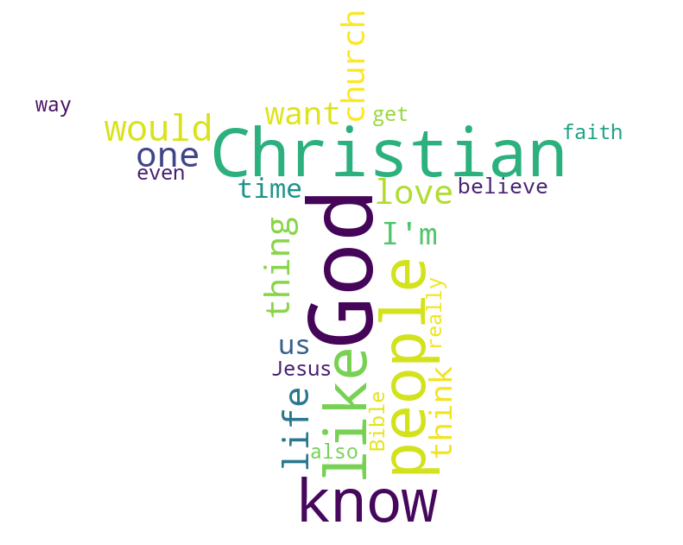

In [15]:
get_wordcloud(reddit_df[reddit_df['topic'] == reddit_df['topic'].unique()[0]]['content'],max_words=25)

In [16]:
print(f'Word cloud for {reddit_topics[1]}')

Word cloud for atheism


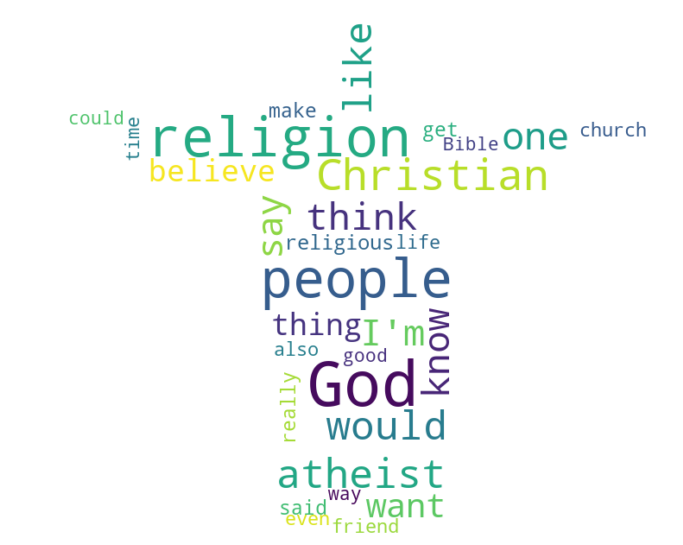

In [17]:
get_wordcloud(reddit_df[reddit_df['topic'] == reddit_df['topic'].unique()[1]]['content'])

## Feature Engineering : Train test split

### Creating X and y

In [18]:
# One hot encode the target class
if filename=='reddit_legal_doc.csv':
    y = reddit_df['topic'].map(lambda x : 1 if x == 'AskDocs' else 0 )
if filename == 'reddit_atheism_christianity.csv':
    y = reddit_df['topic'].map(lambda x : 1 if x == 'Christianity' else 0 )


In [19]:
# Create X
X = reddit_df['content']

In [20]:
from sklearn.model_selection import train_test_split
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print(f'X_train_1:{X_train_1.shape} y_train:{y_train_1.shape} X_test:{X_test.shape} y_test:{y_test.shape}')

X_train_1:(2033,) y_train:(2033,) X_test:(509,) y_test:(509,)


In [22]:
# Futher split X_train to obtain validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42, stratify=y_train_1)
print(f'X_train:{X_train.shape} y_train:{y_train.shape}\nX_val:{X_val.shape} y_val:{y_val.shape} \
\nX_test:{X_test.shape} y_test:{y_test.shape}')

X_train:(1626,) y_train:(1626,)
X_val:(407,) y_val:(407,) 
X_test:(509,) y_test:(509,)


In [23]:
# Check the distributions of y_train, y_val, y_test
print(f'y_train distribution:\n{y_train.value_counts(normalize=True)}')
print(f'y_val distribution:\n{y_val.value_counts(normalize=True)}')
print(f'y_test distribution:\n{y_test.value_counts(normalize=True)}')
# It appears that the distribution of target classes are equal in all three classes

y_train distribution:
1    0.53936
0    0.46064
Name: topic, dtype: float64
y_val distribution:
1    0.538084
0    0.461916
Name: topic, dtype: float64
y_test distribution:
1    0.53831
0    0.46169
Name: topic, dtype: float64


### Baseline accuracy

In [24]:
reddit_df['topic'].value_counts(normalize=True)

Christianity    0.538946
atheism         0.461054
Name: topic, dtype: float64

## NLP Pipeline

### Tokenizing, Stemming/Lemming and Vectorization

We will embed the NLP pre-processing steps right into sklearn's count vectorizer and ti-df vectorizer

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvec = CountVectorizer()

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.model_selection import GridSearchCV

In [26]:
# Create an array that will keep track of all models created in this notebook
models_collection = dict()

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

def add_model_to_scoreboard(model_name, model):
#     models_collection.add((model_name, model))
    if models_collection.get(model_name):
        print(f"Warning, {model_name} is replaced.")
    models_collection[model_name] = model

    
def get_f1(conf):
    tn, fp, fn, tp = conf.ravel()
    precision= tp/(tp+fp)
    sensitivity = tp/(tp+fn)
    return 2*((precision*sensitivity)/(precision+sensitivity))
    
def get_precision(conf):
    tn, fp, fn, tp = conf.ravel()
    return tp/(tp+fp)

def get_sensitivity(conf):
    tn, fp, fn, tp = conf.ravel()
    return tp / ( tp + fn )
    
def get_model_scoreboard(optimize_by='F1', model_dic = models_collection, X=X_val, y=y_val ):
    '''
    Returns dictionary containing a pandas dataframe of the models in this notebook sorted by scores (F1 by default),
    and the best model
    '''
    
        
    training_scores =[]
    val_scores=[]
    model_names = []
    auc_roc_scores = [] 
    f1_scores = []
    precision_scores = []
    sensitivity_scores = []
    best_model_trained = dict()
    
    for model_name, model in model_dic.items():
        if type(model) == GridSearchCV:
            best_model = model.best_estimator_
            best_model.fit(X_train, y_train)
        else:
            best_model = model
        best_model_trained[model_name] = best_model
        training_scores.append(best_model.score(X_train,y_train))
        val_scores.append(best_model.score(X,y))
        model_names.append(model_name)
        
        
        # ROC Scores
        pos_preds = best_model.predict_proba(X)[:,1]
        roc_auc = roc_auc_score(y, pos_preds)
        auc_roc_scores.append(roc_auc)
        
        # F1 Scores
        #Confusion Matrix
        conf = confusion_matrix(y, best_model.predict(X))
        f1_scores.append(get_f1(conf))
        
        precision_scores.append(get_precision(conf))
        sensitivity_scores.append(get_sensitivity(conf))
        
    models = pd.DataFrame({'Model': model_names, 'Training Score': training_scores, 'Validation Score': val_scores,
                          'Auc Roc': auc_roc_scores, 'Sensitivity/Recall': sensitivity_scores, 
                           'Precision': precision_scores , 'F1': f1_scores  })
    models.sort_values(by=optimize_by, ascending=False, inplace=True)
    best_estimator_name = models.iloc[0]['Model']
    return {'df':models, 'best_estimator_': best_model_trained[best_estimator_name], 'best_estimator_name': best_estimator_name }





def get_scores(model, X=X_val, y=y_val):
    '''
    Takes a GridSearchCV model as in input, uses the best parameters in that model to generate a new model and 
    fit on the entire training set. 
    Scores shown refers to the scores on validation set.
    '''

    train_score = model.score(X_train,y_train)
    val_score = model.score(X,y)
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {val_score}')
    
    #Confusion Matrix
    conf = confusion_matrix(y, model.predict(X))
    print(f"Confusion Matrix:\n{conf}")
    tn, fp , fn , tp = conf.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")
    
    precision = tp/(tp+fp)
    print(f"Precision: {precision}")
    
    preds = model.predict_proba(X)
    preds = [ x[1] for x in preds]

    scores_df = pd.DataFrame({'y': y , 'y_pred': preds })
    
    
    roc_auc = roc_auc_score(y, scores_df['y_pred'])
    print(f"Area under ROC curve: {roc_auc}")
    
    #f1 score
    f1 = get_f1(conf)
    print(f"F1 score: {f1}")
    
    return {'confusion':conf, 'train':train_score,'val':val_score, 'specificity': specificity, 'sensitivity' : sensitivity,
            'precision':precision, 'roc_auc_score': roc_auc, 'f1': f1}
    

In [28]:
from sklearn.metrics import roc_curve
def get_roc_curve(model):
    '''
    Plots a ROC graph of a given model
    '''
    pos_preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, pos_preds, pos_label=1)
    
    plt.figure(figsize=(14,8))
    # Plot ROC curve
    plt.plot(fpr,tpr, label='ROC Curve')
    plt.plot([0,1],[0,1], linestyle='--', label='baseline')

    # Label axes.
    plt.title(f"ROC Curve with AUC = {round(roc_auc_score(y_val, pos_preds),3)}", fontsize=22)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=18)
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);


In [29]:
def get_probability_dist(model):
    '''
    Plots the Probability distribution graph for a given model
    '''
    preds = model.predict_proba(X_val)
    preds = [ x[1] for x in preds]

    scores_df = pd.DataFrame({'y': y_val , 'y_pred': preds })
    # Showing the distribution of y_pred when y == 1
    scores_df[scores_df['y'] == 1]

    fig,ax = plt.subplots(figsize=(15,9))
    # When outcome = 1 
    ax.hist(data=scores_df[scores_df['y'] == 1], x='y_pred', color='g', alpha=0.5, label="Outcome = 1", bins=25);

    #When outcome = 0
    ax.hist(data=scores_df[scores_df['y'] == 0], x='y_pred', color='r', alpha=0.5, label="Outcome = 0", bins=25);
    ax.legend(fontsize=20)
    
    ax.vlines(x=0.5, ymin=0, ymax = scores_df.shape[0]*0.15, color='b',linestyle ='--')
    
    
    ax.set_title("Distribution of Probabilities")
    ax.set_xlabel("Predicted Probabilities ")
    ax.set_ylabel("Frequency")
    return ax

In [30]:
# Instantiate stemmer.
from nltk.stem.porter import PorterStemmer

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [ self.wnl.lemmatize(t) for t in word_tokenize(doc) ]
    
class PorterTokenizer(object):
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        return [ self.porter.stem(t) for t in word_tokenize(doc) ]
    
class RegexTokenizer(object):
    
    def __init__(self):
        self.tokenizer = RegexpTokenizer(r'\w+')
        
    def __call__(self, doc):
        return self.tokenizer.tokenize(doc) 
    

In [31]:
def get_best_params(model, param_filter=None ):
    if not param_filter:
        param_filter = [ param for param in model.best_params_.keys() if param != 'cvec__stop_words']
    return [  f"{k} : {v}" for k,v in  model.best_params_.items() if k in param_filter ]

In [32]:
# Create porter tokenized stop words
pt = PorterTokenizer()
porter_tokenized_stopwords = list(set(pt.__call__(" ".join([s for s in stopwords.words("english") + reddit_topics ])))) 

# Obtain the list of stopwords from NLTK english corpora and also include the words in the topic itself as a stopword.
# The stopwords will be tokenized and stemmed (including the two topic words) and removed before training 

In [33]:
# Create lemma tokenized stop words
lt = LemmaTokenizer()
lemma_tokenized_stopwords = list(set([lt.__call__(x)[0] for x in stopwords.words("english") + reddit_topics ] )) 
# The stopwords will be tokenized and lemmatized (including the two topic words) and removed before training 

In [34]:
rt = RegexTokenizer()
regex_tokenized_stopwords = list(set([rt.__call__(x)[0] for x in stopwords.words("english") + reddit_topics ] )) 

### Model 1 : Count Vectorizer - Logistic Regression

For the first model, the pipeline will consist of a simple count vectorizer with a logistic regression classifier

In [35]:
cvec_logreg_pipeline = Pipeline(steps=[('cvec', cvec),('logreg',logreg)])
# Show the parameters
# cvec_logreg_pipeline.get_params()

In [36]:
cvec_logreg_params = { 'cvec__tokenizer' : [RegexTokenizer()],
    'cvec__stop_words': [regex_tokenized_stopwords + [top.lower() for top in reddit_topics ]] , 'cvec__max_df':[0.7], 'cvec__ngram_range':[(1,3)],
                      'logreg__solver':['liblinear'], 'logreg__C': [0.4, 0.7]
}


cvec_logreg_gscv = GridSearchCV(cvec_logreg_pipeline, cvec_logreg_params, cv=5)
cvec_logreg_gscv.fit(X_train,y_train);

add_model_to_scoreboard('Count Vectorizer - Logistic Regression Model', cvec_logreg_gscv)

### Model 2 : Count Vectorizer - Lemmatizer - Logistic Regression

In [37]:
cvec_lemma_logreg_params = {'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__stop_words':[lemma_tokenized_stopwords + [top.lower() for top in reddit_topics ] ], 'cvec__max_df':[0.8], 'cvec__ngram_range':[(1,3)],
                      'logreg__solver':['liblinear'],'logreg__C':[0.3, 0.5], 'logreg__penalty':['l1','l2']
}

cvec_lemma_logreg_gscv = GridSearchCV(cvec_logreg_pipeline, cvec_lemma_logreg_params, cv=5)
cvec_lemma_logreg_gscv.fit(X_train,y_train);

add_model_to_scoreboard('Count Vectorizer- Lemmatizer - Logistic Regression Model', cvec_lemma_logreg_gscv)

#### Scores and best parameters obtained from Grid Search based on this dataset is:

In [38]:
get_best_params(cvec_lemma_logreg_gscv)

['cvec__max_df : 0.8',
 'cvec__ngram_range : (1, 3)',
 'cvec__tokenizer : <__main__.LemmaTokenizer object at 0x0000023176CD8F48>',
 'logreg__C : 0.3',
 'logreg__penalty : l2',
 'logreg__solver : liblinear']

### Model 3 : Count Vectorizer - Porter Stemmer - Logistic Regression

In [39]:
cvec_porter_logreg_params = { 'cvec__tokenizer' : [PorterTokenizer()],
    'cvec__stop_words':[porter_tokenized_stopwords + ['becau'] + [top.lower() for top in reddit_topics ] ] , 'cvec__max_df':[0.7], 'cvec__ngram_range':[(1,3)],
                      'logreg__solver':['liblinear']
}

cvec_porter_logreg_gscv = GridSearchCV(cvec_logreg_pipeline, cvec_porter_logreg_params, cv=5)
cvec_porter_logreg_gscv.fit(X_train,y_train);

add_model_to_scoreboard('Count Vectorizer- PorterStemmer - Logistic Regression Model', cvec_porter_logreg_gscv)

### Model 4 : Count Vectorizer - Lemmatizer - Multinomial Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [41]:
cvec_nb_pipeline = Pipeline(steps=[('cvec', cvec),('mnb',mnb)])
# Show the parameters
# cvec_nb_pipeline.get_params()

In [42]:
cvec_lemma_nb_params = { 'cvec__tokenizer':[LemmaTokenizer()], 'cvec__stop_words':[lemma_tokenized_stopwords + [top.lower() for top in reddit_topics ]],
     'cvec__max_df':[0.7, 1.0 ], 'cvec__ngram_range':[(1,3)]           
}

cvec_lemma_nb_gs = GridSearchCV(cvec_nb_pipeline, cvec_lemma_nb_params, cv=5 )
cvec_lemma_nb_gs.fit(X_train,y_train)

add_model_to_scoreboard('Count Vectorizer - Lemmatizer - MultinomialNB', cvec_lemma_nb_gs)

### Model 5 : TF-IDF - Lemmatizer - Multinomial Naive Bayes

In [43]:
# Instantiate tf-idf vectorizer
tvec = TfidfVectorizer()

In [44]:
tfidf_lemmatizer_nb_pipeline = Pipeline(steps=[('tvec', tvec),('mnb',mnb)])
# tfidf_lemmatizer_nb_pipeline.get_params()

In [45]:
# Create grid search parameters
tfidf_lemmatizer_nb_params = {
    'tvec__tokenizer':[LemmaTokenizer()], 'tvec__stop_words': [lemma_tokenized_stopwords + [top.lower() for top in reddit_topics ] ],
    'tvec__min_df':[1], 'tvec__max_df':[1.0],'tvec__ngram_range':[(1,2)], 
    'tvec__max_features':[3000]
}

# Create grid search for tfidf lemmatizer
tfidf_lemmatizer_nb_gs = GridSearchCV(tfidf_lemmatizer_nb_pipeline, tfidf_lemmatizer_nb_params, cv=5 )
tfidf_lemmatizer_nb_gs.fit(X_train,y_train)
add_model_to_scoreboard('Tf-Idf - Lemmatizer - MultinomialNB', tfidf_lemmatizer_nb_gs)

Notes:
- tvec_max_features 
    - 8000 > None , 5000
    - 3000 > 1000
- tvec__min_df
    - 1 > 50, 10
- tvec__max_df
    - 1.0 > 0.7
- tvec__ngrams:
    - (1,2) > (1,3)

### Model 6 : TF-IDF - Lemmatizer - Multinomial Naive Bayes Model 2

In [46]:
# Create grid search parameters
tfidf_lemmatizer_nb_params2 = {
    'tvec__tokenizer':[LemmaTokenizer()], 'tvec__stop_words': [lemma_tokenized_stopwords + [top.lower() for top in reddit_topics ]],
    'tvec__min_df':[3, 5 ], 'tvec__max_df':[ 0.8 ],'tvec__ngram_range':[(1,2)], 
    'tvec__max_features':[3000], 'mnb__alpha': [1.0]
}

# Create grid search for tfidf lemmatizer
tfidf_lemmatizer_nb_gs2 = GridSearchCV(tfidf_lemmatizer_nb_pipeline, tfidf_lemmatizer_nb_params2, cv=5 )
tfidf_lemmatizer_nb_gs2.fit(X_train,y_train)
add_model_to_scoreboard('Tf-Idf - Lemmatizer - MultinomialNB - 2 ', tfidf_lemmatizer_nb_gs2)

#### Intepreting Model 4

### Model 5 : Gradient Boosting Classifier

In [47]:
# Try a Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gboost = GradientBoostingClassifier()
tfidf_lemmatizer_gb_pipeline = Pipeline(steps=[('tvec', tvec),('gb', gboost)])
# tfidf_lemmatizer_gb_pipeline.get_params()

In [48]:
tfidf_lemmatizer_gb_params={
    'tvec__tokenizer':[LemmaTokenizer()], 'tvec__stop_words': [lemma_tokenized_stopwords + [top.lower() for top in reddit_topics ]],
    'tvec__min_df':[3 ], 'tvec__max_df':[ 0.8 ],'tvec__ngram_range':[(1,2)], 
    'tvec__max_features':[3000],
    'gb__learning_rate':[0.1], 'gb__n_estimators':[200], 'gb__max_leaf_nodes': [None], 'gb__min_samples_leaf':[10,50]
}

tfidf_lemmatizer_gb_gs = GridSearchCV(tfidf_lemmatizer_gb_pipeline, tfidf_lemmatizer_gb_params, cv=5 ).fit(X_train,y_train)
add_model_to_scoreboard('Tf-Idf - Lemmatizer - GradientBoosting', tfidf_lemmatizer_gb_gs)

## Model Benchmarks

In [49]:
scoreboard= get_model_scoreboard(optimize_by='Sensitivity/Recall')
scoreboard['df']

,Model,Training Score,Validation Score,Auc Roc,Sensitivity/Recall,Precision,F1
3,Count Vectorizer - Lemmatizer - MultinomialNB,0.998155,0.766585,0.803617,0.913242,0.724638,0.808081
5,Tf-Idf - Lemmatizer - MultinomialNB - 2,0.901599,0.820639,0.896592,0.863014,0.814655,0.838137
4,Tf-Idf - Lemmatizer - MultinomialNB,0.903444,0.818182,0.896034,0.858447,0.813853,0.835556
0,Count Vectorizer - Logistic Regression Model,0.998770,0.808354,0.876591,0.853881,0.802575,0.827434
1,Count Vectorizer- Lemmatizer - Logistic Regres...,0.997540,0.805897,0.876105,0.844749,0.804348,0.824053
2,Count Vectorizer- PorterStemmer - Logistic Reg...,0.999385,0.805897,0.862674,0.835616,0.809735,0.822472
6,Tf-Idf - Lemmatizer - GradientBoosting,0.912054,0.783784,0.863038,0.808219,0.793722,0.800905


### Optimizing for Recall
In our case, the cost of the False Negatives(Classifying Christians as atheists, won't receive church updates) is higher than of False Positives (Classifying atheists as Christians, will wrongly receive updates ), as we do not mind emailing the brochurs by mistake to a few atheists, but we do not want to miss out any existing Christians as their numbers are already dwindling. Thus, it make sense for us to optimize the model based on Sensitivity/Recall, as shown in the sorted table above. 


### Plotting the AUC ROC Curve of the best model

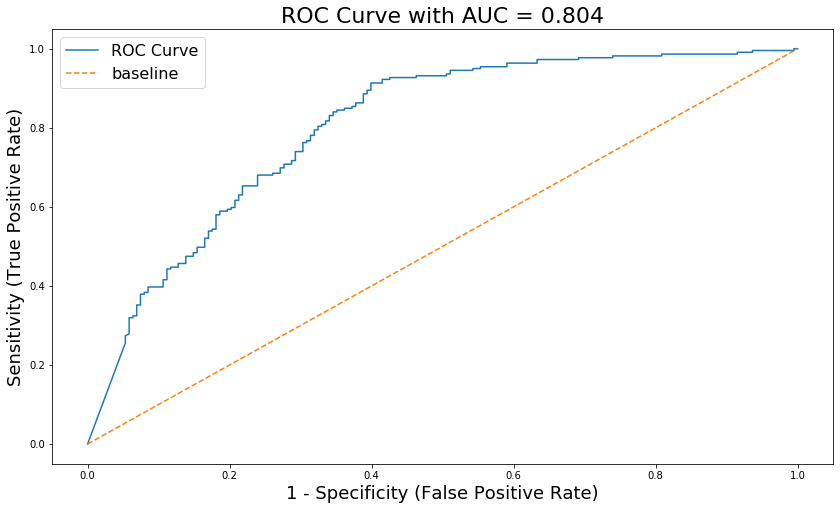

In [50]:
get_roc_curve(scoreboard['best_estimator_'])

As the choosen model was optimized for Sensitivity, it did not have a very good Area Under Curve for ROC score.

### Plotting the distribution of probabilities

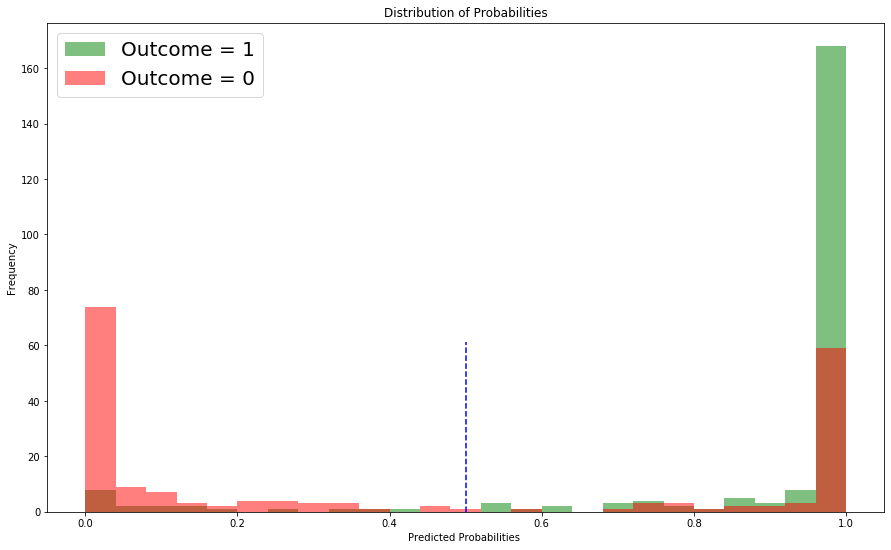

In [51]:
get_probability_dist(scoreboard['best_estimator_'])

As the model was optimized for sensitivity, we could see that there are more False Positives than there are False Negatives in the probability distribution. It fits our requirements where False Negatives are minimized. We choose not to lower the default threshold of 0.5 as the model is good enough as it is (we do not want to further increase False positives)


## Visualizing the most frequent words in each subreddit

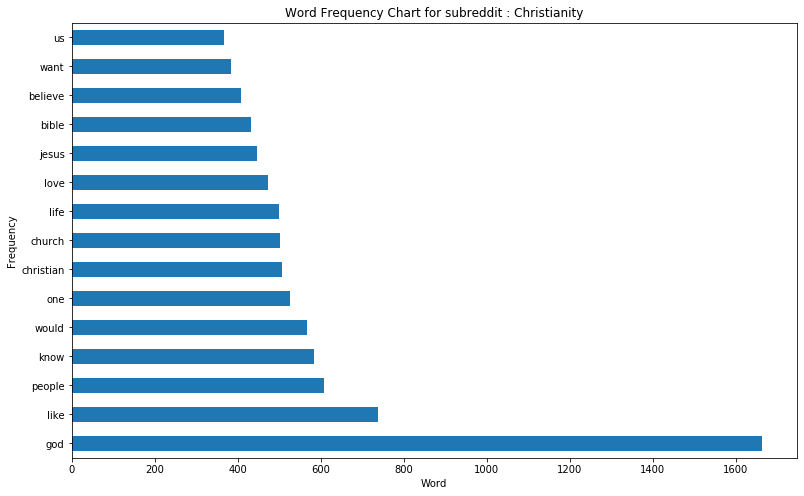

In [52]:
# To visualize the Count Vectorizer
def get_top_words(subreddit):
    cvec = CountVectorizer(stop_words= stopwords.words("english") , max_df=0.7, max_features=80)
    X_train_cvec_transformed = cvec.fit_transform(reddit_df[reddit_df['topic'] == subreddit ]['content'])
    X_train_cvec_pd = pd.DataFrame(X_train_cvec_transformed.toarray(), columns=cvec.get_feature_names())
    X_train_cvec_pd = X_train_cvec_pd[[col for col in X_train_cvec_pd.columns if col not in set(stopwords.words("english")) ]]
    X_train_cvec_pd = X_train_cvec_pd[X_train_cvec_pd.sum().sort_values(ascending=False).index]

    plt.figure(figsize=(13,8))
    X_train_cvec_pd.iloc[:,:15].sum().plot.barh()
    plt.title(f'Word Frequency Chart for subreddit : {subreddit}')
    plt.xlabel("Word")
    plt.ylabel("Frequency");
    

get_top_words( reddit_topics[0])

From the bar chart above we could see that life, love, jesus , bible are among the most distinguising words used by Christians. Most frequent words like god, like, people, would, one,  christian, church, also appear frequently in the atheism category as shown below

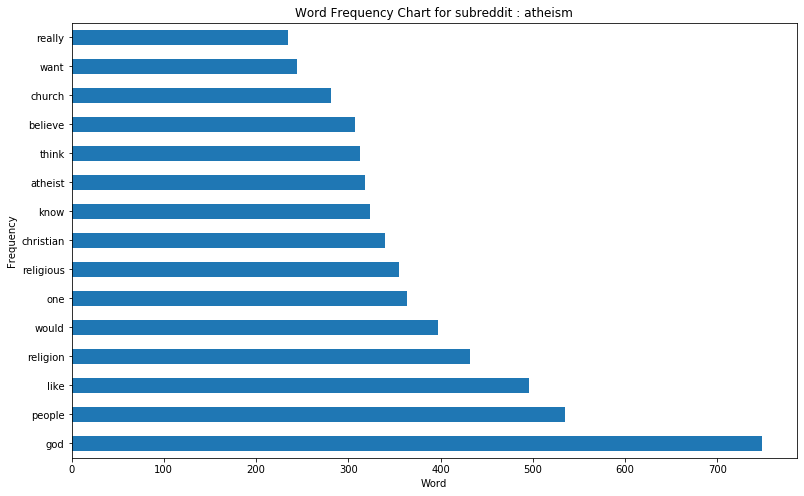

In [53]:
get_top_words( reddit_topics[1])

From the chart above we can see the most frequent words used by the atheist community. Aside from common words like 'god, people, like' , most distinguising words used by atheists are religion, religious, atheist, think and really.

## Export the best Model

In [54]:
import joblib

joblib.dump(scoreboard['best_estimator_'], filename.split('.')[0] + '_best_model.pkl' , compress = 1)

['reddit_atheism_christianity_best_model.pkl']

## Running the final model on Test set

In [55]:
final_model = scoreboard['best_estimator_']
## Final model is the best model trained on the entire X_train and y_train with no cross validations


In [56]:
# Final model scores on the validation set
best_model_scores = get_model_scoreboard(model_dic={'final_model':final_model})
best_model_scores['df']

,Model,Training Score,Validation Score,Auc Roc,Sensitivity/Recall,Precision,F1
0,final_model,0.998155,0.766585,0.803617,0.913242,0.724638,0.808081


In [57]:
# Final model scores on the Test set
best_model_scores = get_model_scoreboard(model_dic={'final_model':final_model}, X=X_test, y=y_test)
best_model_scores['df']

,Model,Training Score,Validation Score,Auc Roc,Sensitivity/Recall,Precision,F1
0,final_model,0.998155,0.722986,0.785541,0.90146,0.684211,0.777953


On the final test set, our model is able to perform with a sensitivity score of 0.92, which is a reasonably high score.

## Conclusion

In [58]:
print(f"The best performing model is {scoreboard['best_estimator_name']} \nwith a F1 score of {scoreboard['df'].iloc[0]['F1']} \
and sensitivity of {scoreboard['df'].iloc[0]['Sensitivity/Recall']} on the Test Set.")

The best performing model is Count Vectorizer - Lemmatizer - MultinomialNB 
with a F1 score of 0.8080808080808081 and sensitivity of 0.91324200913242 on the Test Set.
